In [1]:
import numpy as np
import pandas as pd
from linearmodels import PooledOLS, PanelOLS, RandomEffects
from linearmodels.panel import compare
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy.linalg as la
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Fixed and Random Effects models

In the following function both Fixed and Random Effects models are implemented. The Fixed Effects analysis can be switched off to perform just a Ramdon effects
analysis. In case both the Fixed and Random effects model is run the Hausman Test is performed to compare the two.

## Tests
The following tests can be done on the data setting "pOLS=True" _and_ "tests=True"  
- White Test for heteroskedasticity  
- Breusch-Pagan Test for heteroskedasticity  
- Durbin-Watson Test for autocorrelation  

## Data Scaling
Data scaling with a standard scaler can be performed by setting "scale=True". The standard scaler is given by the transformation:  
$$x\rightarrow\frac{x-\mu}{\sigma}$$
This ensures that the coefficients are of $\mathcal{O}(1)$. This does not affect the p-value of the coefficients.

## Dealing with $-\infty$
The number of confirmed cases is transformed with a $\log_{10}$. This gives a $-\infty$ for 0 values. These $-\infty$ are replaced by $10^{-6}$.
Varying them to $10^{-4}$ does not change the results.

## variations in the analysis
The analysis is broken down into three regions  
- East Coast  
- Southern States  
- West Coast  

and into two phases: Phase I and Phase II

In [2]:
def hausman(fe, re):
    ''' The Hausman test to check for fixed effects
        arguments:
            fe : Fixed Effects Models result object
            re : Random Effects Models result object
        returns:
            chi2: chi squared for the test
            df: degrees of freedom for the test
            pval: p value of the test
    '''
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

def analysis(region, period, exog, fixedEffects=False, pOLS=False, tests=False, scale=True):
    ''' Perfomes the full analysis including a linear OLS, Heteroskedasticity tests, 
        Autocorrelation tests, Random Effects modeling, Fixed Effects Modeling, Hausman test
        and model comparison
        arguments:
            region: a string to specify the region for which the analysis is being done. Can be "east", "west" or "south"
            period: a string to specify the period for which the analysis is being done. Can be "1" or "2"
            exog: a list of strings to specify the exogenous variables. Can be any combination of:
                    'Density', 'Non-White', 'Poverty', 'Income', 'Unemployment',
                    'Uninsured', 'Employed', 'Labor', 'Transit', 'Mean Commute',
                    'Senior Citizen', 'Gini', 'Comorbidities'
            fixedEffects: a boolean to specify whether to perform the fixed effects analysis. This will include Fixed Effects modeling, Hausman Test
                          and model comparison with random effects.
            pOLS: a boolean for performing pooled OLS necessary for heteroskedasticity tests
            tests: a boolean to turn on the heteroskedasticity (White Test, Breusch-Pagan Test) and autocorrelations (Durbin-Watson Test) tests
            scale: a boolean to turn on standard scaling of data
    '''
    df_data = pd.read_csv('../data/panel_merged_period_'+period+'_weekly_norm_diff_confirmed.csv', usecols=['FIPS', 'week']+exog+['confirmed_cases', 'region'], index_col=['FIPS', 'week'])
    df_data['week'] = pd.Categorical(df_data.index.get_level_values('week').to_list())
    df_data = df_data[df_data.region == region].drop(columns=['region'])
    df_data['confirmed_cases'] = np.log10(df_data['confirmed_cases'].clip(lower=0)).replace([-np.inf], 1e-6)
    
    if scale:
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df_data.iloc[:,:4])
        df_data['Density'] = df_scaled.T[0]
        df_data['Non-White'] = df_scaled.T[1]
        df_data['Income'] = df_scaled.T[2]
        df_data['Unemployment'] = df_scaled.T[3]
        
    if tests and not pOLS:
        print("Set pOLS to True if tests is set to True")
        pOLS = True
    
    if pOLS:
        # Pooled OLS
        x = sm.tools.add_constant(df_data[exog])
        y = df_data['confirmed_cases']
        model = PooledOLS(y, x)
        pooled_result = model.fit(cov_type='clustered', cluster_entity=True)
        pooled_fv = pooled_result.predict().fitted_values
        pooled_res = pooled_result.resids

        print(pooled_result)
        print('\n\n')

        # plot to check heteroskedasticity
        plt.figure(figsize=(6,4))
        plt.scatter(pooled_fv, pooled_res, s=5)
        plt.grid(':', alpha=0.5)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Heteroskedasticity Test')
        plt.tight_layout()
        plt.show()
        print('\n\n')
        
        if tests:
            # White Test (for heteroskedasticity)
            pooled_ols = pd.concat([df_data, pooled_res], axis=1)
            pooled_ols = pooled_ols.drop(columns=['week'])

            x = sm.tools.add_constant(df_data['Income'])
            white_test = het_white(pooled_ols['residual'], x)

            labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
            table = [[label, white_test[i]] for i, label in enumerate(labels)]
            print("White Test")
            print(tabulate(table, headers=['stat', 'value'], tablefmt='psql'))

            # Breusch-Pagan Test (for heteroskedasticity)
            bp_test = het_breuschpagan(pooled_ols['residual'], x)
            labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
            table = [[label, bp_test[i]] for i, label in enumerate(labels)]
            print("\nBreusch-Pagan Test")
            print(tabulate(table, headers=['stat', 'value'], tablefmt='psql'))

            # Durbin-Watson Test (for autocorrelation)
            dw_test = durbin_watson(pooled_ols['residual'])
            print("\nDurbin-Watson Test: {:5f}\n\n".format(dw_test))
    
    # Random Effect Model
    x = sm.tools.add_constant(df_data[exog])
    y = df_data['confirmed_cases']

    model_re = RandomEffects(y, x)
    re_result = model_re.fit()

    print(re_result)
    
    if fixedEffects:
        
        # Fixed Effect Model
        model_fe = PanelOLS(y, x, entity_effects=True)
        fe_result = model_fe.fit()
        
        print('\n\n')
        print(fe_result)
        
        # Hausman Test
        hausman_result = hausman(fe_result, re_result)
        labels = ['chi-squared', 'degrees of freedom', 'p-value']
        table = [[label, hausman_result[i]] for i, label in enumerate(labels)]
        print("Hausman Test")
        print(tabulate(table, headers=['stat', 'value'], tablefmt='psql'))
        
        # Compare between Fixed Effects and Random Effects
        print('\n\n')
        print(compare({"RE": re_result, "FE": fe_result}))

_______________
# East Coast

## Phase 1

                          PooledOLS Estimation Summary                          
Dep. Variable:        confirmed_cases   R-squared:                        0.1080
Estimator:                  PooledOLS   R-squared (Between):              0.5920
No. Observations:                3036   R-squared (Within):               0.0000
Date:                Sat, Jan 15 2022   R-squared (Overall):              0.1080
Time:                        01:25:12   Log-likelihood                   -3483.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      91.784
Entities:                        1043   P-value                           0.0000
Avg Obs:                       2.9108   Distribution:                  F(4,3031)
Min Obs:                       0.0000                                           
Max Obs:                       22.000   F-statistic (robust):             55.261
                            

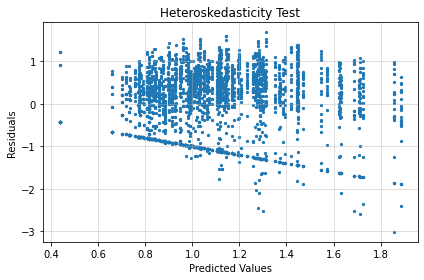




White Test
+----------+--------------+
| stat     |        value |
|----------+--------------|
| LM-Stat  | 54.1763      |
| LM p-val |  1.72093e-12 |
| F-Stat   | 27.5531      |
| F p-val  |  1.38441e-12 |
+----------+--------------+

Breusch-Pagan Test
+----------+--------------+
| stat     |        value |
|----------+--------------|
| LM-Stat  | 51.0966      |
| LM p-val |  8.79315e-13 |
| F-Stat   | 51.937       |
| F p-val  |  7.19984e-13 |
+----------+--------------+

Durbin-Watson Test: 0.385931


                        RandomEffects Estimation Summary                        
Dep. Variable:        confirmed_cases   R-squared:                        0.0599
Estimator:              RandomEffects   R-squared (Between):              0.5920
No. Observations:                3036   R-squared (Within):               0.0000
Date:                Sat, Jan 15 2022   R-squared (Overall):              0.1080
Time:                        01:25:13   Log-likelihood                   -3419.4


In [3]:
analysis('east', '1', ['Density', 'Unemployment', 'Income', 'Non-White'], pOLS=True, tests=True)

## Phase 2

In [4]:
analysis('east', '2', ['Density', 'Unemployment', 'Income', 'Non-White'])

                        RandomEffects Estimation Summary                        
Dep. Variable:        confirmed_cases   R-squared:                        0.0109
Estimator:              RandomEffects   R-squared (Between):              0.2295
No. Observations:                3588   R-squared (Within):               0.0000
Date:                Sat, Jan 15 2022   R-squared (Overall):              0.0515
Time:                        01:25:36   Log-likelihood                   -3160.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      9.9123
Entities:                        1043   P-value                           0.0000
Avg Obs:                       3.4401   Distribution:                  F(4,3583)
Min Obs:                       0.0000                                           
Max Obs:                       26.000   F-statistic (robust):             9.9123
                            

_______________
# West Coast

## Phase 1

In [5]:
analysis('west', '1', ['Density', 'Unemployment', 'Income', 'Non-White'])

                        RandomEffects Estimation Summary                        
Dep. Variable:        confirmed_cases   R-squared:                        0.0737
Estimator:              RandomEffects   R-squared (Between):              0.6444
No. Observations:                2926   R-squared (Within):               0.0000
Date:                Sat, Jan 15 2022   R-squared (Overall):              0.1515
Time:                        01:25:38   Log-likelihood                   -2923.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      58.064
Entities:                        1610   P-value                           0.0000
Avg Obs:                       1.8174   Distribution:                  F(4,2921)
Min Obs:                       0.0000                                           
Max Obs:                       22.000   F-statistic (robust):             58.064
                            

## Phase 2

In [6]:
analysis('west', '2', ['Density', 'Unemployment', 'Income', 'Non-White'])

                        RandomEffects Estimation Summary                        
Dep. Variable:        confirmed_cases   R-squared:                        0.0539
Estimator:              RandomEffects   R-squared (Between):              0.6054
No. Observations:                3458   R-squared (Within):               0.0000
Date:                Sat, Jan 15 2022   R-squared (Overall):              0.2007
Time:                        01:25:39   Log-likelihood                   -2858.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      49.146
Entities:                        1610   P-value                           0.0000
Avg Obs:                       2.1478   Distribution:                  F(4,3453)
Min Obs:                       0.0000                                           
Max Obs:                       26.000   F-statistic (robust):             49.146
                            

_______________
# Southern States

## Phase 1

In [7]:
analysis('south', '1', ['Density', 'Unemployment', 'Income', 'Non-White'])

                        RandomEffects Estimation Summary                        
Dep. Variable:        confirmed_cases   R-squared:                        0.0280
Estimator:              RandomEffects   R-squared (Between):              0.3890
No. Observations:               30668   R-squared (Within):             2.22e-16
Date:                Sat, Jan 15 2022   R-squared (Overall):              0.0702
Time:                        01:25:40   Log-likelihood                -3.561e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      221.10
Entities:                        1665   P-value                           0.0000
Avg Obs:                       18.419   Distribution:                 F(4,30663)
Min Obs:                       0.0000                                           
Max Obs:                       22.000   F-statistic (robust):             221.10
                            

## Phase 2

In [8]:
analysis('south', '2', ['Density', 'Unemployment', 'Income', 'Non-White'])

                        RandomEffects Estimation Summary                        
Dep. Variable:        confirmed_cases   R-squared:                        0.0096
Estimator:              RandomEffects   R-squared (Between):              0.2011
No. Observations:               36244   R-squared (Within):            -2.22e-16
Date:                Sat, Jan 15 2022   R-squared (Overall):              0.0397
Time:                        01:25:41   Log-likelihood                -2.476e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      87.431
Entities:                        1665   P-value                           0.0000
Avg Obs:                       21.768   Distribution:                 F(4,36239)
Min Obs:                       0.0000                                           
Max Obs:                       26.000   F-statistic (robust):             87.431
                            